# Run level 2A, 2B and 3 pipelines on MRS data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) July 5th 2018

This notebook demonstrates the execution of the level 2A, 2B, and 3 pipelines for MRS data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The files used in this notebook is a MIRISim simulation of a point source with power-law (alpha=0) plus emission lines spectrum. The simulated observation is a four-point dither on the source with the channels 1 and 2, and the SHORT disperser. 

The steps applied are:

- ramps to slopes pipeline (Detector1Pipeline)

- CALSPEC2 steps and spectral extraction from each dither (Spec2Pipeline)

- combination of dithers and spectral extraction (Spec3Pipeline)

- manual conversion of extracted spectra to Jy 


#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input, output location and source type
Since we know the simulation is of a point source, we can set the source type metadata to 'POINT' at this stage as that information is used later in spectral extraction. Otherwise, the pipeline will set the default source type for MRS which is 'EXTENDED'

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'MRS_demo_data'
input_dir = 'MRS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the source type as 'POINT'
for f in input_files:
    with datamodels.MIRIRampModel(f) as dm:
        dm.meta.target.source_type = 'POINT'
        dm.save(os.path.join(input_dir, dm.meta.filename))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFUSHORT	 2	 50	 FAST	 12	 SHORT



Filename: MRS_demo_data/det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     110   ()      
  1  SCI           1 ImageHDU        54   (1032, 1024, 50, 2)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 50, 2)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 50, 2)   float32   
  5  REFOUT        1 ImageHDU        12   (258, 1024, 50, 2)   float32   
  6  ASDF          1 BinTableHDU     11   5469R x 1C   [B]   


#### show the last frame of the first integration for each file

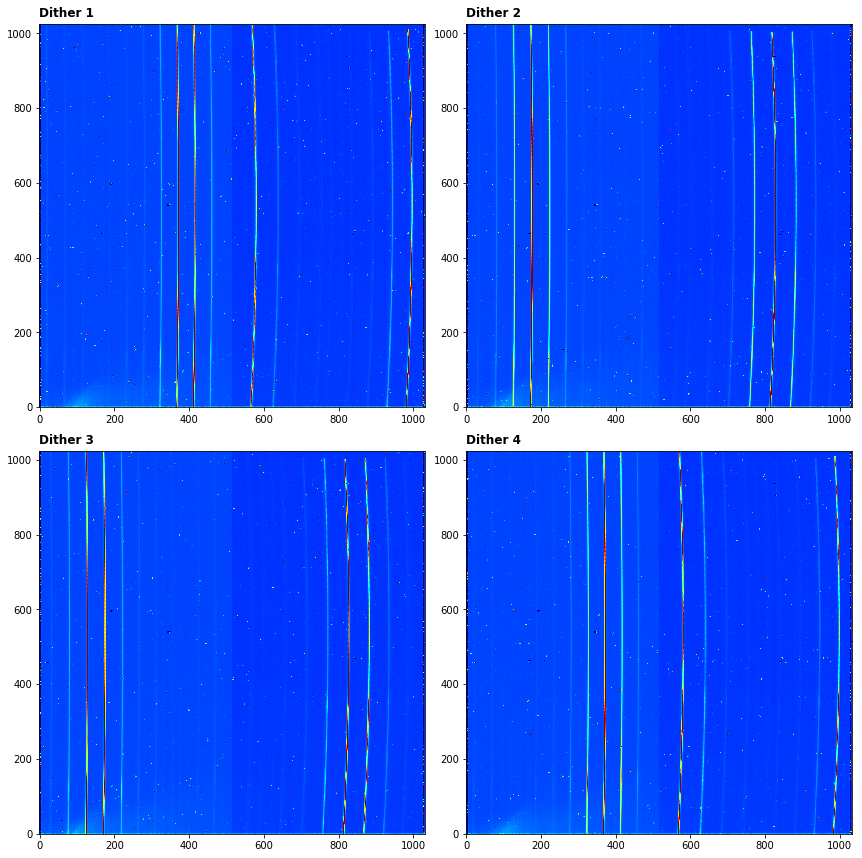

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for f in input_files:
    # open the input image as a jwst data model
    with datamodels.MIRIRampModel(f) as in_dm:

        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)



    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.

    


#### run pipeline
We pass the level 1B files (demo data). We need to explicitly skip the IPC step. The output level 2A files will be saved in the output_dir as '*_rate.fits'

There is an issue currently affecting the pipelining of MIRISim data through the refpix which is being looked into. For now, we just skip this step.


In [6]:
for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'refpix': {'skip': True}})


2019-02-01 16:51:05,993 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-02-01 16:51:05,996 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2019-02-01 16:51:05,997 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-02-01 16:51:06,000 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2019-02-01 16:51:06,002 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2019-02-01 16:51:06,004 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-02-01 16:51:06,006 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2019-02-01 16:51:06,009 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2019-02-01 16:51:06,010 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2019-02-01 16:51:06,012 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instanc

2019-02-01 16:52:40,458 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-02-01 16:52:40,468 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-02-01 16:52:40,512 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-02-01 16:52:41,256 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-02-01 16:52:41,924 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-02-01 16:52:45,961 - stpipe.Detector1Pipeline.jump - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/jump/twopoint_difference.py:83: RuntimeWarning: invalid value encountered in sqrt
  poisson_noise = np.sqrt(np.abs(med_diffs))

2019-02-01 16:53:02,127 - stpipe.Detector1Pipeline.jump - I

2019-02-01 16:59:56,677 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0056.fits'.
2019-02-01 16:59:56,678 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2019-02-01 16:59:56,679 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits'.
2019-02-01 16:59:56,680 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0022.fits'.
2019-02-01 16:59:56,681 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2019-02-01 16:59:56,682 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_mi

2019-02-01 17:02:03,471 - stpipe.Detector1Pipeline.ramp_fit - INFO - Effective integration time per group: 2.77504
2019-02-01 17:07:09,873 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:391: RuntimeWarning: divide by zero encountered in true_divide
  inv_var_p4[num_int, :, :, :] = 1./var_p4[num_int, :, :, :]

2019-02-01 17:07:10,497 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:395: RuntimeWarning: divide by zero encountered in true_divide
  var_p3[num_int, :, :] = 1./ s_inv_var_p3[num_int, :, :]

2019-02-01 17:07:12,990 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:457: RuntimeWarning: divide by zero encountered in true_

2019-02-01 17:08:35,816 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES={} is a power of 2; correction not needed
2019-02-01 17:08:35,817 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped
2019-02-01 17:08:35,818 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done
2019-02-01 17:08:35,897 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-01 17:08:35,930 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0022.fits
2019-02-01 17:08:38,716 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done
2019-02-01 17:08:38,800 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-01 17:08:38,862 - stpipe.Detector1Pipeline.saturat

2019-02-01 17:16:57,130 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/utils.py:666: RuntimeWarning: invalid value encountered in sqrt
  cubemod.err = np.sqrt(var_both3)

2019-02-01 17:16:57,161 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 50
2019-02-01 17:16:57,162 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2
2019-02-01 17:16:57,745 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done
2019-02-01 17:16:58,098 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-01 17:16:58,152 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2019-02-01 17:16:58,153 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2019-02-01 17:16:58,154 - stpipe.Detec

2019-02-01 17:17:05,024 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0007.fits
2019-02-01 17:18:22,316 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2019-02-01 17:18:22,446 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-01 17:18:23,697 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done
2019-02-01 17:18:23,767 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-02-01 17:18:24,421 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done
2019-02-01 17:18:24,501 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1.fits>,

2019-02-01 17:25:18,151 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: None
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Note that since MIRISim does not add straylight, we can skip the straylight correction step.

In [9]:
for f in level2A_files:
    Spec2Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir, 
                       steps={'straylight':{'skip':True}})


2019-02-01 17:25:18,375 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2019-02-01 17:25:18,386 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2019-02-01 17:25:18,390 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2019-02-01 17:25:18,393 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2019-02-01 17:25:18,397 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2019-02-01 17:25:18,402 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2019-02-01 17:25:18,403 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2019-02-01 17:25:18,408 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.
2019-02-01 17:25:18,410 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.
2019-02-01 17:25:18,411 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2019-02-01 17:25:18,414 - stpipe.Sp

2019-02-01 17:25:33,455 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.
2019-02-01 17:25:33,456 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done
2019-02-01 17:25:33,551 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-02-01 17:25:33,585 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits
2019-02-01 17:25:33,662 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-01 17:25:33,663 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-01 17:25:33,664 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
201

2019-02-01 17:27:47,115 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.
2019-02-01 17:27:47,117 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2019-02-01 17:27:47,118 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2019-02-01 17:27:47,120 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2019-02-01 17:27:47,122 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2019-02-01 17:27:47,124 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2019-02-01 17:27:47,126 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-02-01 17:27:47,129 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2019-02-01 17:27:47,232 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('MRS_demo_data_pipelined/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits',).
2019-02-01 17:27:47,410 - stpipe

2019-02-01 17:28:02,400 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-01 17:28:03,451 - stpipe.Spec2Pipeline.fringe - INFO - The DQ values in the reference file will NOT be used to update the    DQ values in the output DQ array.
2019-02-01 17:28:03,453 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done
2019-02-01 17:28:03,592 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-02-01 17:28:03,636 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits
2019-02-01 17:28:03,640 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2019-02-01 17:28:03,642 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2019-02-01 17:28:03,642 - stpipe.Spec2Pipeline.photom - I

2019-02-01 17:30:20,903 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('MRS_demo_data_pipelined/det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits',).
2019-02-01 17:30:21,074 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2019-02-01 17:30:21,085 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2019-02-01 17:30:21,086 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2019-02-01 17:30:21,086 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2019-02-01 17:30:21,087 -

2019-02-01 17:30:37,164 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2019-02-01 17:30:37,165 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2019-02-01 17:30:37,165 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT
2019-02-01 17:30:37,166 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2019-02-01 17:30:37,166 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2019-02-01 17:30:37,326 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-02-01 17:30:37,344 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2019-02-01 17:30:37,472 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-02-01 17:30:37,473 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2019-02-01 17:30:37,474 - stpipe.Spec2Pipeline.cube_buil

2019-02-01 17:32:48,157 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2019-02-01 17:32:48,157 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2019-02-01 17:32:48,158 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2019-02-01 17:32:48,158 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0002.fits'.
2019-02-01 17:32:48,159 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2019-02-01 17:32:48,159 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2019-02-01 17:32:48,160 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0021.asdf'.
2019-02-01 17:32:48,161 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/patrickkavan

2019-02-01 17:33:02,782 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2019-02-01 17:33:02,783 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2019-02-01 17:33:02,784 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: ra-dec
2019-02-01 17:33:02,784 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: msm
2019-02-01 17:33:02,785 - stpipe.Spec2Pipeline.cube_build - INFO - Power Weighting distance : 2.000000
2019-02-01 17:33:02,844 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes covers the MIRI Channels: ['1', '2']
2019-02-01 17:33:02,845 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'SHORT']
2019-02-01 17:33:02,846 - stpipe.Spec2Pipeline.cube_build - INFO - Reading  cube parameter file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0002.fits
2019-02-01 17:33:05,707 - stpipe.Spec2Pipeline.cube_build -

### check of output

The level 2B pipeline for the MRS produces three files for each input:

_cal.fits - the calibrated level 2B file from each dither

_s3d.fits - the cube from each dither

_x1d.fits - the 1d spectrum from each dither


In [10]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
cube_files = glob.glob(os.path.join(output_dir,'*_s3d.fits'))

#### level 2B file

In [11]:
with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('straylight: %s' % dm.meta.cal_step.straylight)
    print('fringe: %s' % dm.meta.cal_step.fringe)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
straylight: None
fringe: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

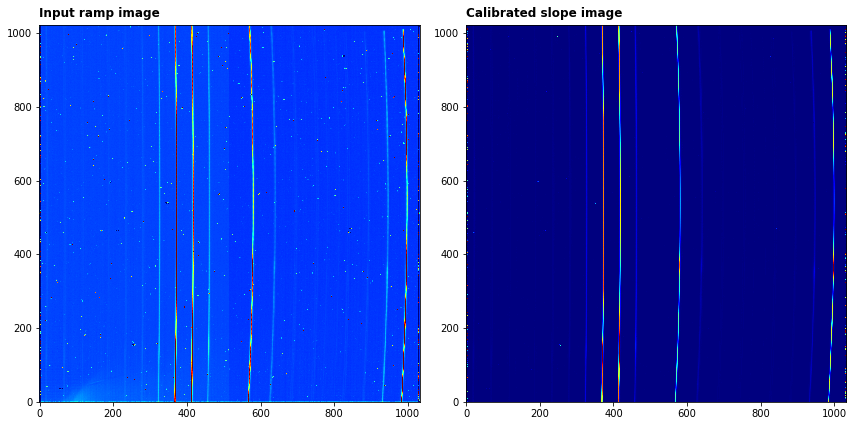

In [12]:
# open the input image as a jwst data model
with datamodels.MIRIRampModel(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=500)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

#### Look at cube file. We'll look at the first dither only

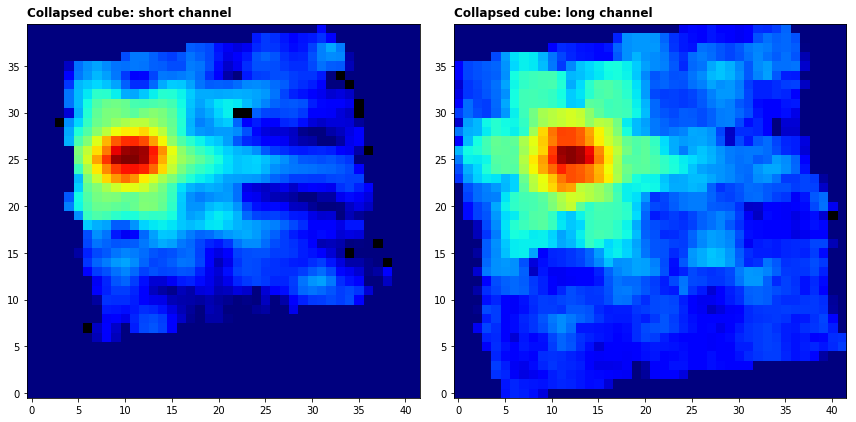

In [13]:
# open the cube as a jwst data model
with datamodels.open(cube_files[0]) as cube_dm:
    
    # plot--------------------------------------
    # sum some of the the frames in each channel
    # Note the user may have to adjust the scaling
    # parameters
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e5))
    axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(np.sum(cube_dm.data[3000:3200], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e5))
    axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

### Level 3 pipeline

The Spec3Pipeline is working in jwst-0.9.6 but some of the steps are still in development (e.g., the background matching). 

Since most people are probably interested in building cubes and extracting spectra, we just use the cube_build and extract_1d steps to produce level 3 cube and spectral products in the next few cells. A full run of Spec3Pipeline itself can be found below where the difference in the cubes due to the additional steps can be seen.

We first create an association file in the output directory containing the list of level 2B files ("_cal.fits") produced by the level 2B pipeline. 

#### create the level 3 association using the asn_from_list tool

In [14]:
call(["asn_from_list", "-o", "MRS_asn.json"] + level2B_files + ["--product-name", "dither"])


0

In [15]:
from jwst.extract_1d import extract_1d_step
from jwst.cube_build import cube_build_step

dms = datamodels.open("MRS_asn.json")
cube_dms = cube_build_step.CubeBuildStep.call(dms, save_results=True, output_dir=output_dir)
spec_dms = extract_1d_step.Extract1dStep.call(cube_dms, output_use_model=True, save_results=True, 
                                              output_dir=output_dir)


2019-02-01 17:35:24,951 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2019-02-01 17:35:25,177 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args (<ModelContainer>,).
2019-02-01 17:35:25,178 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2019-02-01 17:35:25,178 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2019-02-01 17:35:25,179 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2019-02-01 17:35:25,180 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2019-02-01 17:35:25,180 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2019-02-01 17:35:56,388 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI Channels: ['1', '2']
2019-02-01 17:35:56,389 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'SHORT']
2019-02-01 17:35:56,390 - stpipe.CubeBuildStep - INFO - Reading  cube parameter file /Users/patrickkavanagh/crds_m

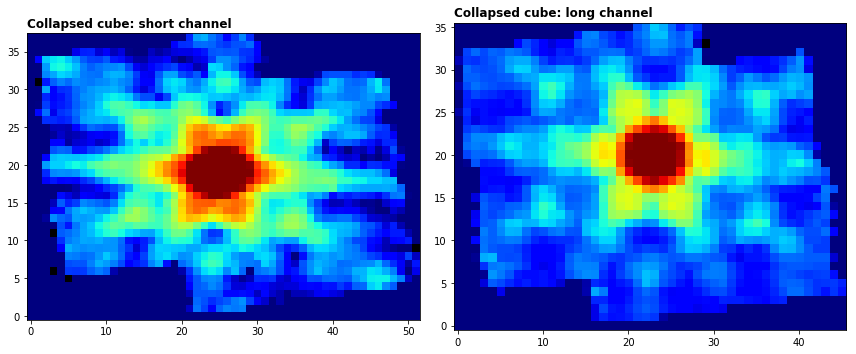

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(cube_dms[0].data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=40,vmax=1e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(cube_dms[1].data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=40,vmax=1e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()



Note that since we have set the source type to 'POINT' above, the extract_1d step will use an aperture extraction and subtract a background with default values. The aperture centre is at pixel x/2, y/2, the radius is y/4, and the background annulus is from the radius to the radius*sqrt(2). In the future, more advanced extraction methods are planned. One can set also the aperture properties using a custom aperture reference file. Please contact pkavanagh@cp.dias.ie if you want to do this.

The extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area.

Note that an additional aperture correction factor for the encircled energy in the aperture should also be applied but we forego this here since the CDPs are currently not available.

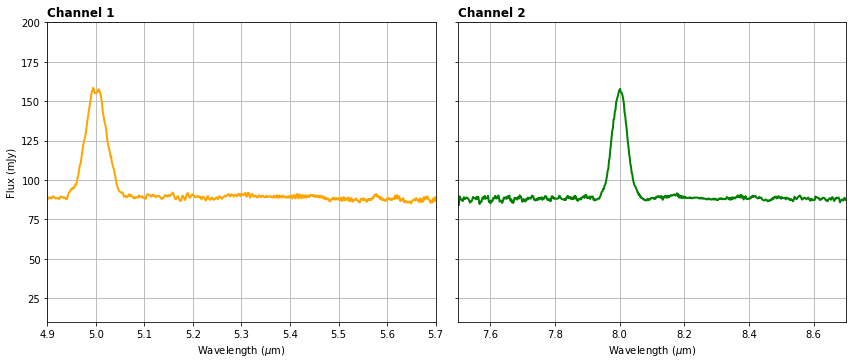

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot the spectrum in the channel 2 wavelength range
spaxel_area = cube_dms[0].meta.wcsinfo.cdelt1 * cube_dms[0].meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(spec_dms[0].spec[0].spec_table['WAVELENGTH'], spec_dms[0].spec[0].spec_table['FLUX'] * spaxel_area, c='orange', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux (mJy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
axs[0].set_xlim(4.9,5.7)
axs[0].set_ylim(10,200)
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].grid()
spaxel_area = cube_dms[1].meta.wcsinfo.cdelt1 * cube_dms[1].meta.wcsinfo.cdelt2 * 3600**2
axs[1].plot(spec_dms[1].spec[0].spec_table['WAVELENGTH'], spec_dms[1].spec[0].spec_table['FLUX']  * spaxel_area, c='g', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1].set_xlim(7.5,8.7)
axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].grid()

plt.tight_layout()
plt.show()

#### Spec3Pipeline
We know produce the same products and plots using Spec3Pipeline itself, which includes background matching and outlier detection.

In [18]:
from jwst.pipeline import Spec3Pipeline
print(Spec3Pipeline.__doc__)



    Spec3Pipeline: Processes JWST spectroscopic exposures from Level 2b to 3.

    Included steps are:
    MIRI MRS background matching (skymatch)
    outlier detection (outlier_detection)
    2-D spectroscopic resampling (resample_spec)
    3-D spectroscopic resampling (cube_build)
    1-D spectral extraction (extract_1d)
    


In [19]:
# create a separate output folder for Spec3Pipeline
spec3pipeline_outdir = 'Spec3Pipeline_output'
if os.path.exists(spec3pipeline_outdir): shutil.rmtree(spec3pipeline_outdir)
os.mkdir(spec3pipeline_outdir)

# read the association and run
dms = datamodels.open("MRS_asn.json")
Spec3Pipeline.call(dms, save_results=True, output_dir=spec3pipeline_outdir,
                  steps={'cube_build': {'save_results': True, 'output_dir': spec3pipeline_outdir},
                         'extract_1d': {'save_results': True, 'output_dir': spec3pipeline_outdir}})

2019-02-01 17:40:42,155 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2019-02-01 17:40:42,159 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2019-02-01 17:40:42,161 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2019-02-01 17:40:42,162 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2019-02-01 17:40:42,165 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-02-01 17:40:42,166 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2019-02-01 17:40:42,567 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args (<ModelContainer>,).
2019-02-01 17:40:50,372 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIFUSHORT_12SHORTexp1_cal.fits' reftypes = ['cubepar', 'drizpars', 'extract1d', 'resol']
2019-02-01 17:40:50,379 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR re

2019-02-01 17:43:50,728 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Blending metadata for 
2019-02-01 17:43:53,296 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Time Create Single IFUcube  = 49.6.s
2019-02-01 17:44:40,791 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Time to interpolate at spaxel values = 1.2.s
2019-02-01 17:44:40,870 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Blending metadata for 
2019-02-01 17:44:43,527 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Time Create Single IFUcube  = 50.1.s
2019-02-01 17:44:43,634 - stpipe.CubeBuildStep - INFO - Number of IFUCube models returned from building single IFUCubes 4 
2019-02-01 17:44:59,350 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2019-02-01 17:44:59,351 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2019-02-01 17:44:59,352 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2019-02-01 17:44:59,353 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2019-02-01 17:44:59,353 

2019-02-01 18:29:44,309 - stpipe.Spec3Pipeline.outlier_detection - INFO - Time Create Single IFUcube  = 2338.1.s
2019-02-01 18:32:08,148 - stpipe.Spec3Pipeline.outlier_detection - INFO - Time to interpolate at spaxel values = 3.4.s
2019-02-01 18:32:08,355 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blending metadata for 
2019-02-01 18:32:16,795 - stpipe.Spec3Pipeline.outlier_detection - INFO - Time Create Single IFUcube  = 152.2.s
2019-02-01 18:32:17,052 - stpipe.CubeBuildStep - INFO - Number of IFUCube models returned from building single IFUCubes 4 
2019-02-01 18:32:31,689 - stpipe.Spec3Pipeline.outlier_detection - INFO - Information on Blotting
2019-02-01 18:32:31,692 - stpipe.Spec3Pipeline.outlier_detection - INFO - Working with instrument MIRI MIRIFUSHORT
2019-02-01 18:32:31,695 - stpipe.Spec3Pipeline.outlier_detection - INFO - shape of sky cube 52.000000 38.000000 929.000000
2019-02-01 18:32:31,697 - stpipe.Spec3Pipeline.outlier_detection - INFO - Instrument MIRI 
2019-02-0

2019-02-01 19:20:37,527 - stpipe.Spec3Pipeline.extract_1d - WARNING - INTSTART not found; assuming a value of 1.
2019-02-01 19:20:37,528 - stpipe.Spec3Pipeline.extract_1d - WARNING - INTEND not found; assuming a value of 2.
2019-02-01 19:20:37,530 - stpipe.Spec3Pipeline.extract_1d - WARNING - There is no INT_TIMES table in the input file.
2019-02-01 19:20:37,755 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in Spec3Pipeline_output/dither_ch1-short_extract_1d.fits
2019-02-01 19:20:37,972 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in Spec3Pipeline_output/dither_ch2-short_extract_1d.fits
2019-02-01 19:20:37,974 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2019-02-01 19:20:37,976 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3
2019-02-01 19:20:37,977 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


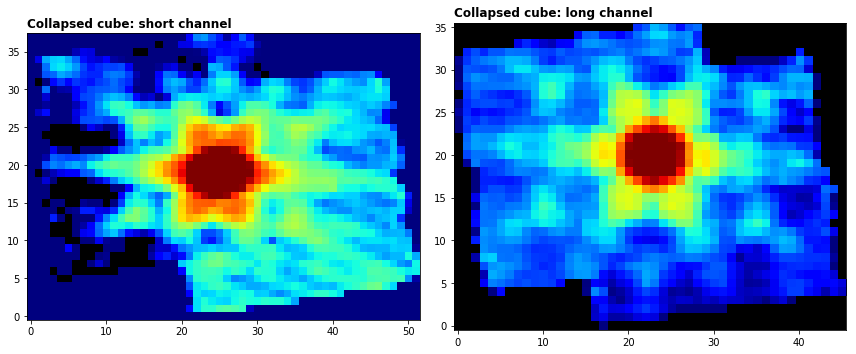

In [20]:
cube_files = sorted(glob.glob(os.path.join(spec3pipeline_outdir, '*s3d.fits')))
ch1_cdm = datamodels.open(cube_files[0])
ch2_cdm = datamodels.open(cube_files[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(ch1_cdm.data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=40,vmax=1e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(ch2_cdm.data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=40,vmax=1e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()


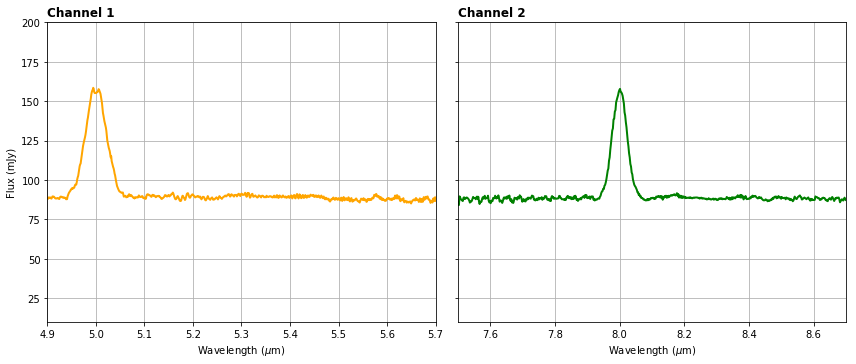

In [21]:
spec_files = sorted(glob.glob(os.path.join(spec3pipeline_outdir, '*1d.fits')))
ch1_sdm = datamodels.open(spec_files[0])
ch2_sdm = datamodels.open(spec_files[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot the spectrum in the channel 2 wavelength range
spaxel_area = ch1_cdm.meta.wcsinfo.cdelt1 * ch1_cdm.meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(ch1_sdm.spec[0].spec_table['WAVELENGTH'], ch1_sdm.spec[0].spec_table['FLUX'] * spaxel_area, c='orange', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux (mJy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
axs[0].set_xlim(4.9,5.7)
axs[0].set_ylim(10,200)

spaxel_area = ch2_cdm.meta.wcsinfo.cdelt1 * ch2_cdm.meta.wcsinfo.cdelt2 * 3600**2
axs[1].plot(ch2_sdm.spec[0].spec_table['WAVELENGTH'], ch2_sdm.spec[0].spec_table['FLUX']  * spaxel_area, c='g', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1].set_xlim(7.5,8.7)

axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].grid()
axs[1].grid()

plt.tight_layout()
plt.show()